# NetPyNE Tutorial 7: Multiscale Network



## Preliminaries

If you are going to run this notebook locally using Jupyter Notebook, start from following instructions https://github.com/Neurosim-lab/netpyne/blob/development/netpyne/tutorials/README.md.

If you are using Open Source Brain or EBRAINS, everything is already set up.

On any other online platform (e.g. on Google Collab) you might need to run the following commmands to install NEURON and NetPyNE using **pip**:
```
!pip install neuron
!pip install netpyne
```

Now we are ready to start the tutorial.

## Compile mechanisms

The cell models require membrane mechanisms (e.g. channel models) that are not built-in to NEURON.  So, now we will compile the necessary mechanisms (in the `mod` directory) using `nrnivmodl`.  You can learn more about mechanisms and `.mod` files in the [NEURON documentation](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html). 

In [8]:
#!nrnivmodl mod


Start time:  2024-11-04 12:42:05.491133




Creating network of 6 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 60 
  Done; cell creation time = 0.06 s.
Making connections...


  E->all: 100%|##########| Creating synaptic connections for 60/60 postsynaptic cells on node 0 (probabilistic connectivity)
  I->E: 100%|##########| Creating synaptic connections for 30/30 postsynaptic cells on node 0 (probabilistic connectivity)


  Number of connections on node 0: 309 
  Done; cell connection time = 0.05 s.
Adding stims...
  Number of stims on node 0: 60 
  Done; cell stims creation time = 0.01 s.
Adding RxD...
  Created Region cyt
  Created Region er
  Created Region cyt_er_membrane
  Created Extracellular Region ecs
  Created Species ca
  Created Species ip3
  Created State ip3r_gate_state
  Created MultiCompartmentReaction serca
  Created MultiCompartmentReaction leak
  Created MultiCompartmentReaction ip3r
  Created Rate ip3rg
  Done; RxD setup time = 2.04 s.
Recording 4 traces of 4 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 48.77 s; real-time ratio: 0.02.

Gathering data...
  Done; gather time = 0.32 s.

Analyzing...
  Cells: 60
  Connections: 369 (6.15 per cell)
  Spikes: 1189 (19.82 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 48.77 s
Plotting recorded cell traces ... cell


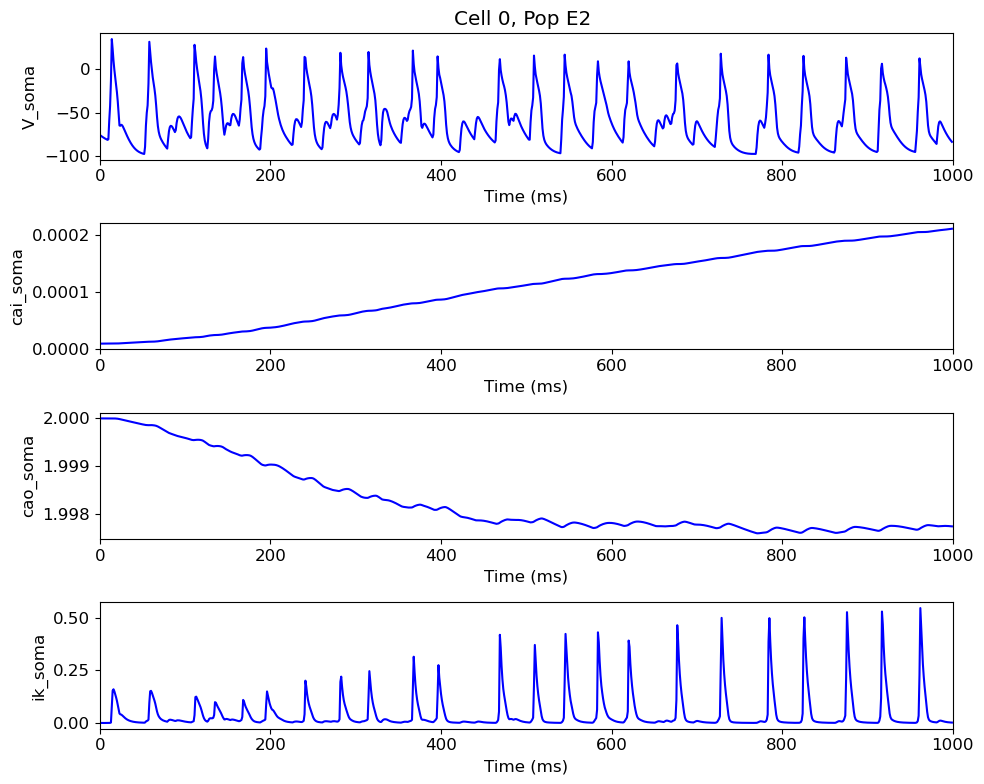

Preparing spike data...
Plotting raster...
Preparing LFP data...
Plotting LFP time series...
Preparing LFP data...
Preparing PSD data...
Plotting LFP power spectral density (PSD)...
Preparing LFP data...
Preparing spectrogram data...
Plotting LFP spectrogram...
Plotting LFP electrode locations...
Plotting 3D cell shape ...

There was an exception in plotShape()


Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/analysis/utils.py", line 75, in wrapper
    return function(*args, **kwargs)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/netpyne/plotting/plotShape.py", line 225, in plotShape
    cb = plt.colorbar(sm, fraction=0.15, shrink=0.5, pad=0.05, aspect=20)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2516, in colorbar
    ret = gcf().colorbar(mappable, cax=cax, ax=ax, **kwargs)
  File "/home/hyunsu/miniconda3/envs/netpyne/lib/python3.10/site-packages/matplotlib/figure.py", line 1215, in colorbar
    raise ValueError(
ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
Traceback (most recent call last):
  File "/home/hyunsu/minicon


There was an exception in plotLFPLocations()
Plotting RxD concentration ...
dict_keys(['spkt', 'spkid', 'V_soma', 'ik_soma', 'cai_soma', 'cao_soma', 't', 'LFP', 'dipoleSum', 'avgRate'])
  min: 1.9963472540769491
  max: 2.000000000000518


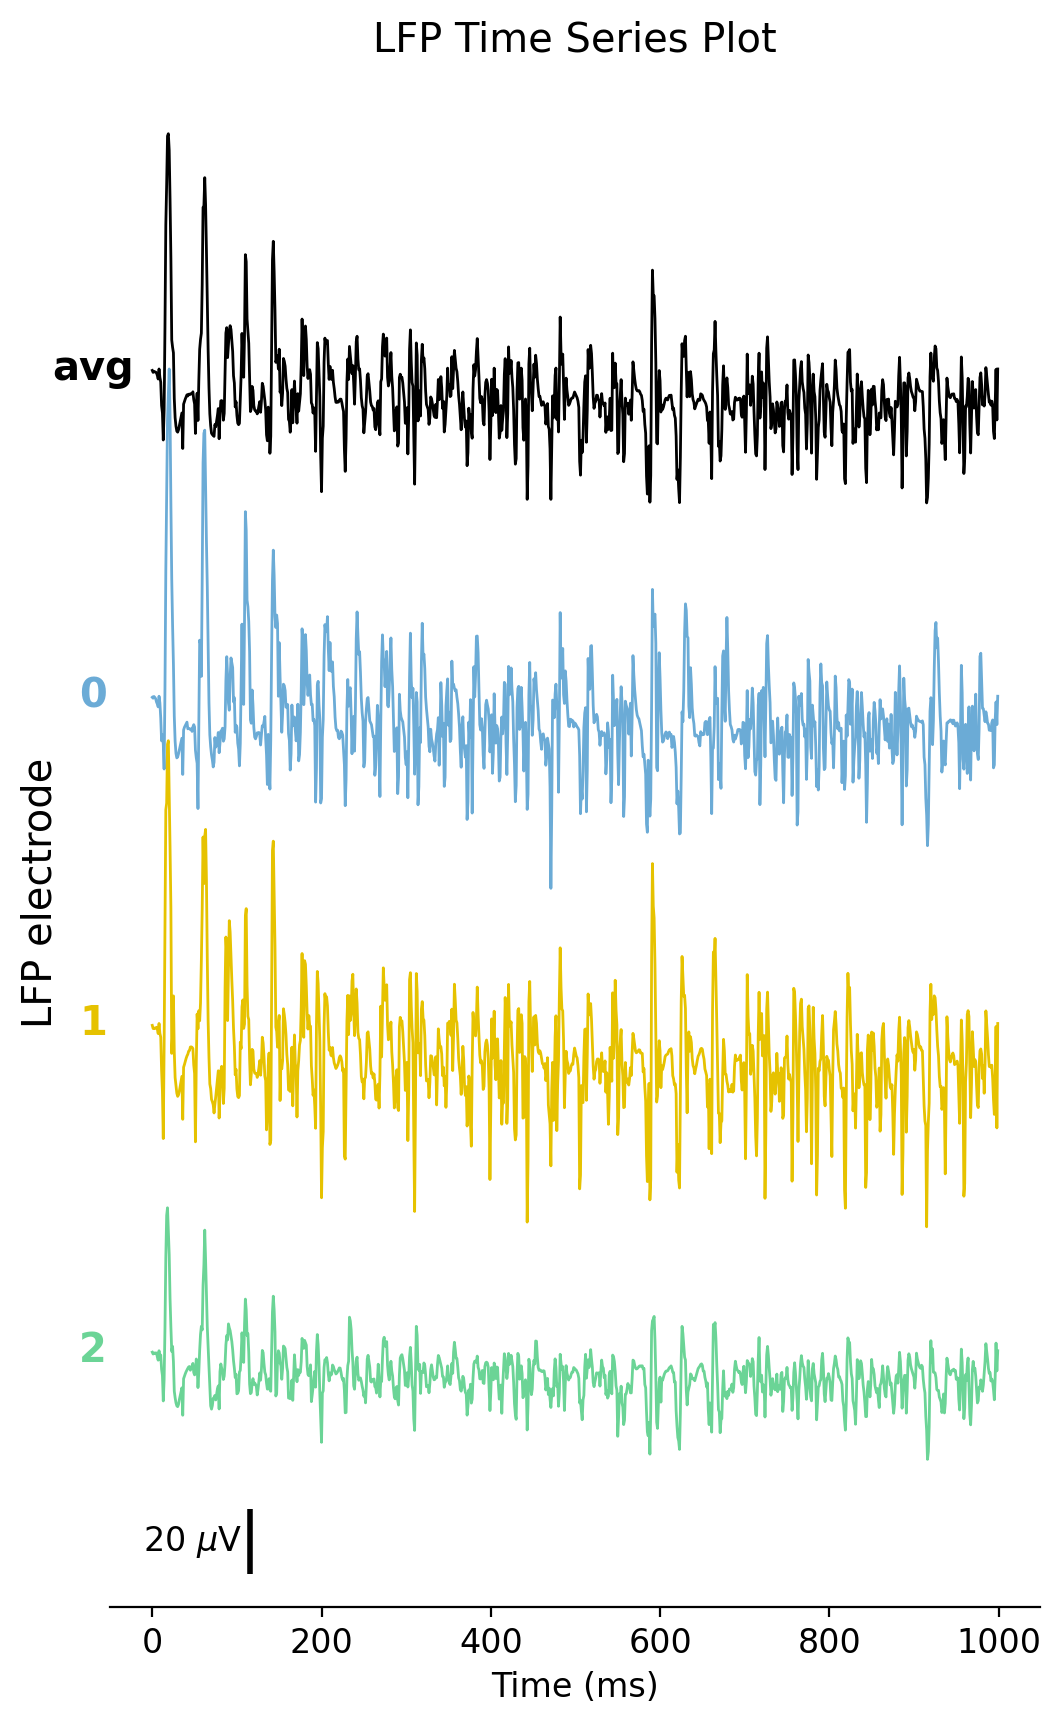

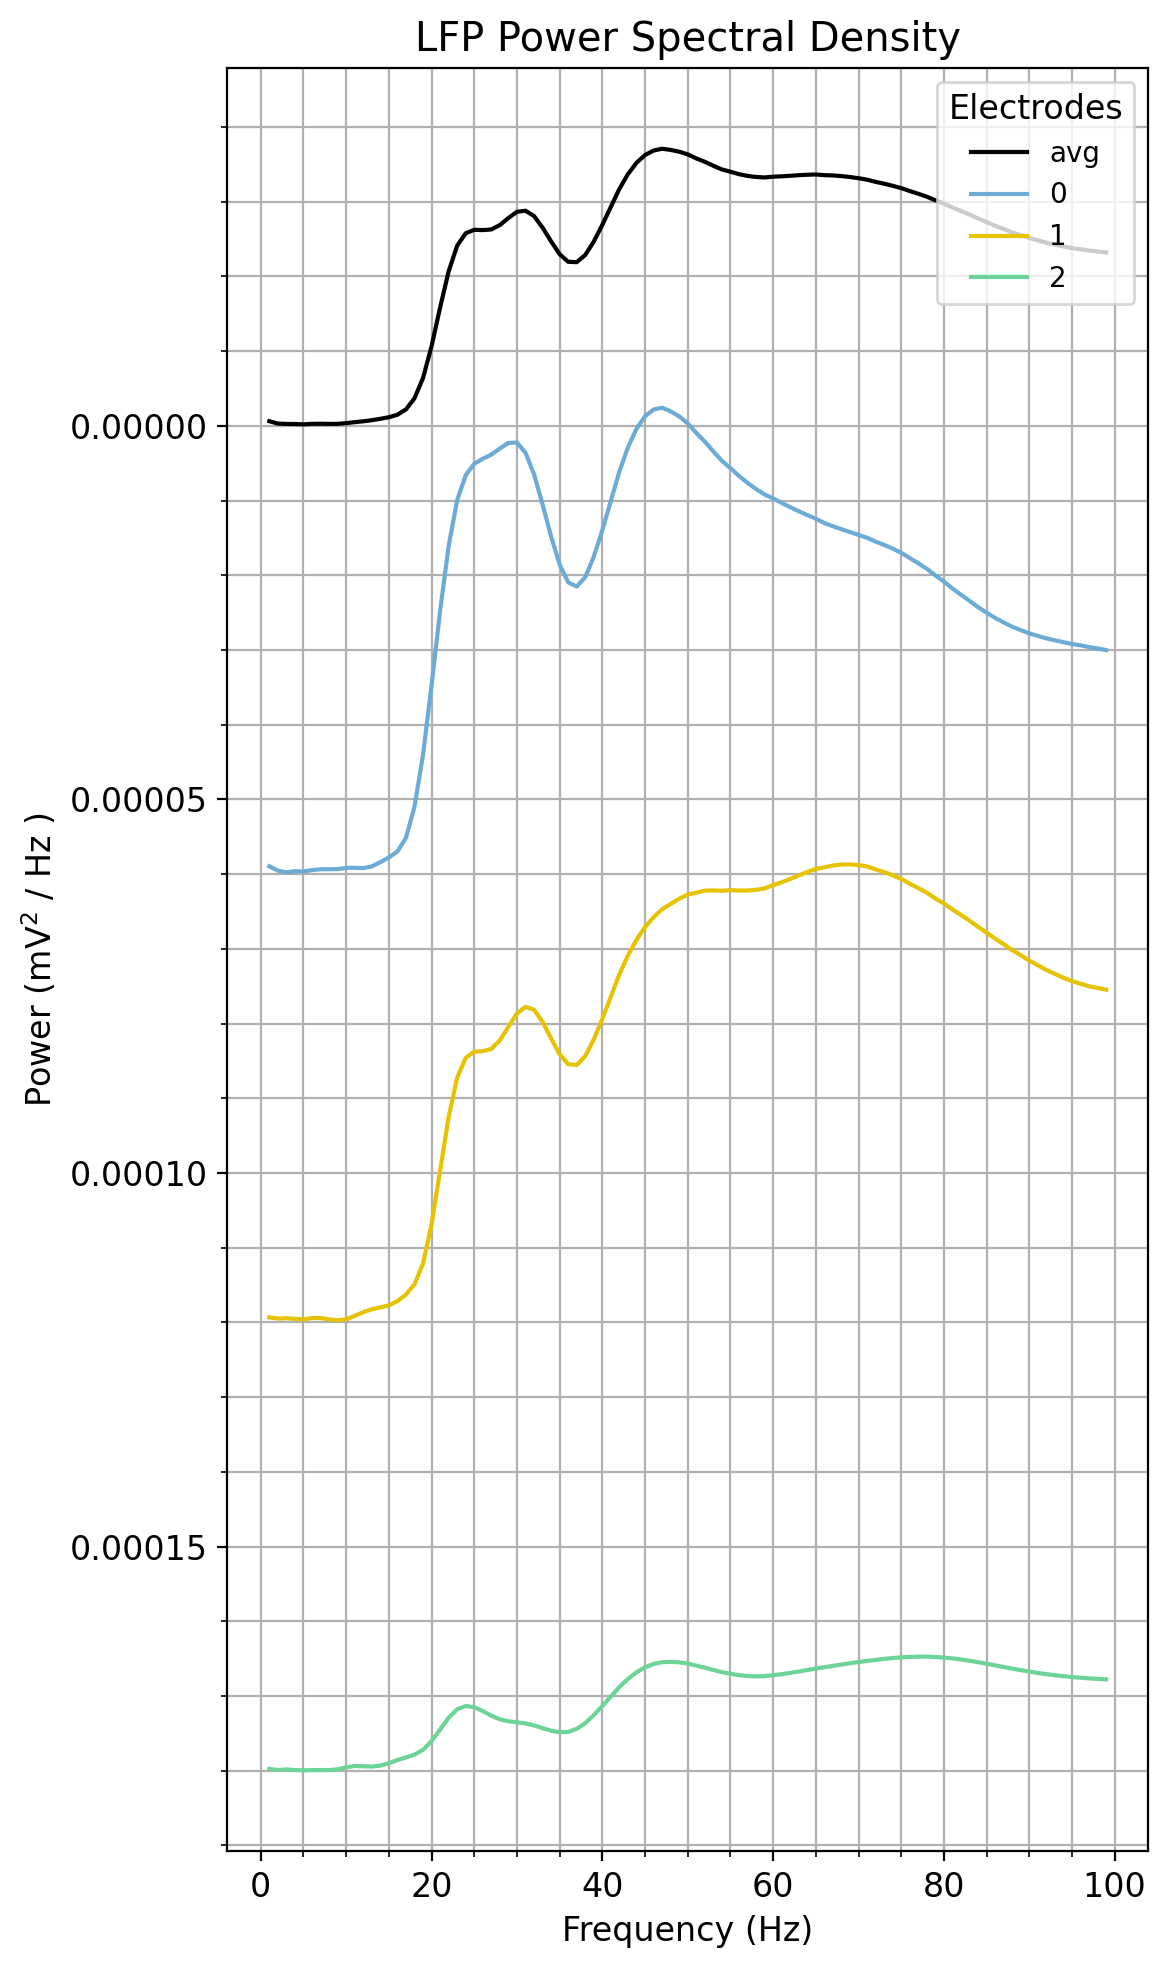

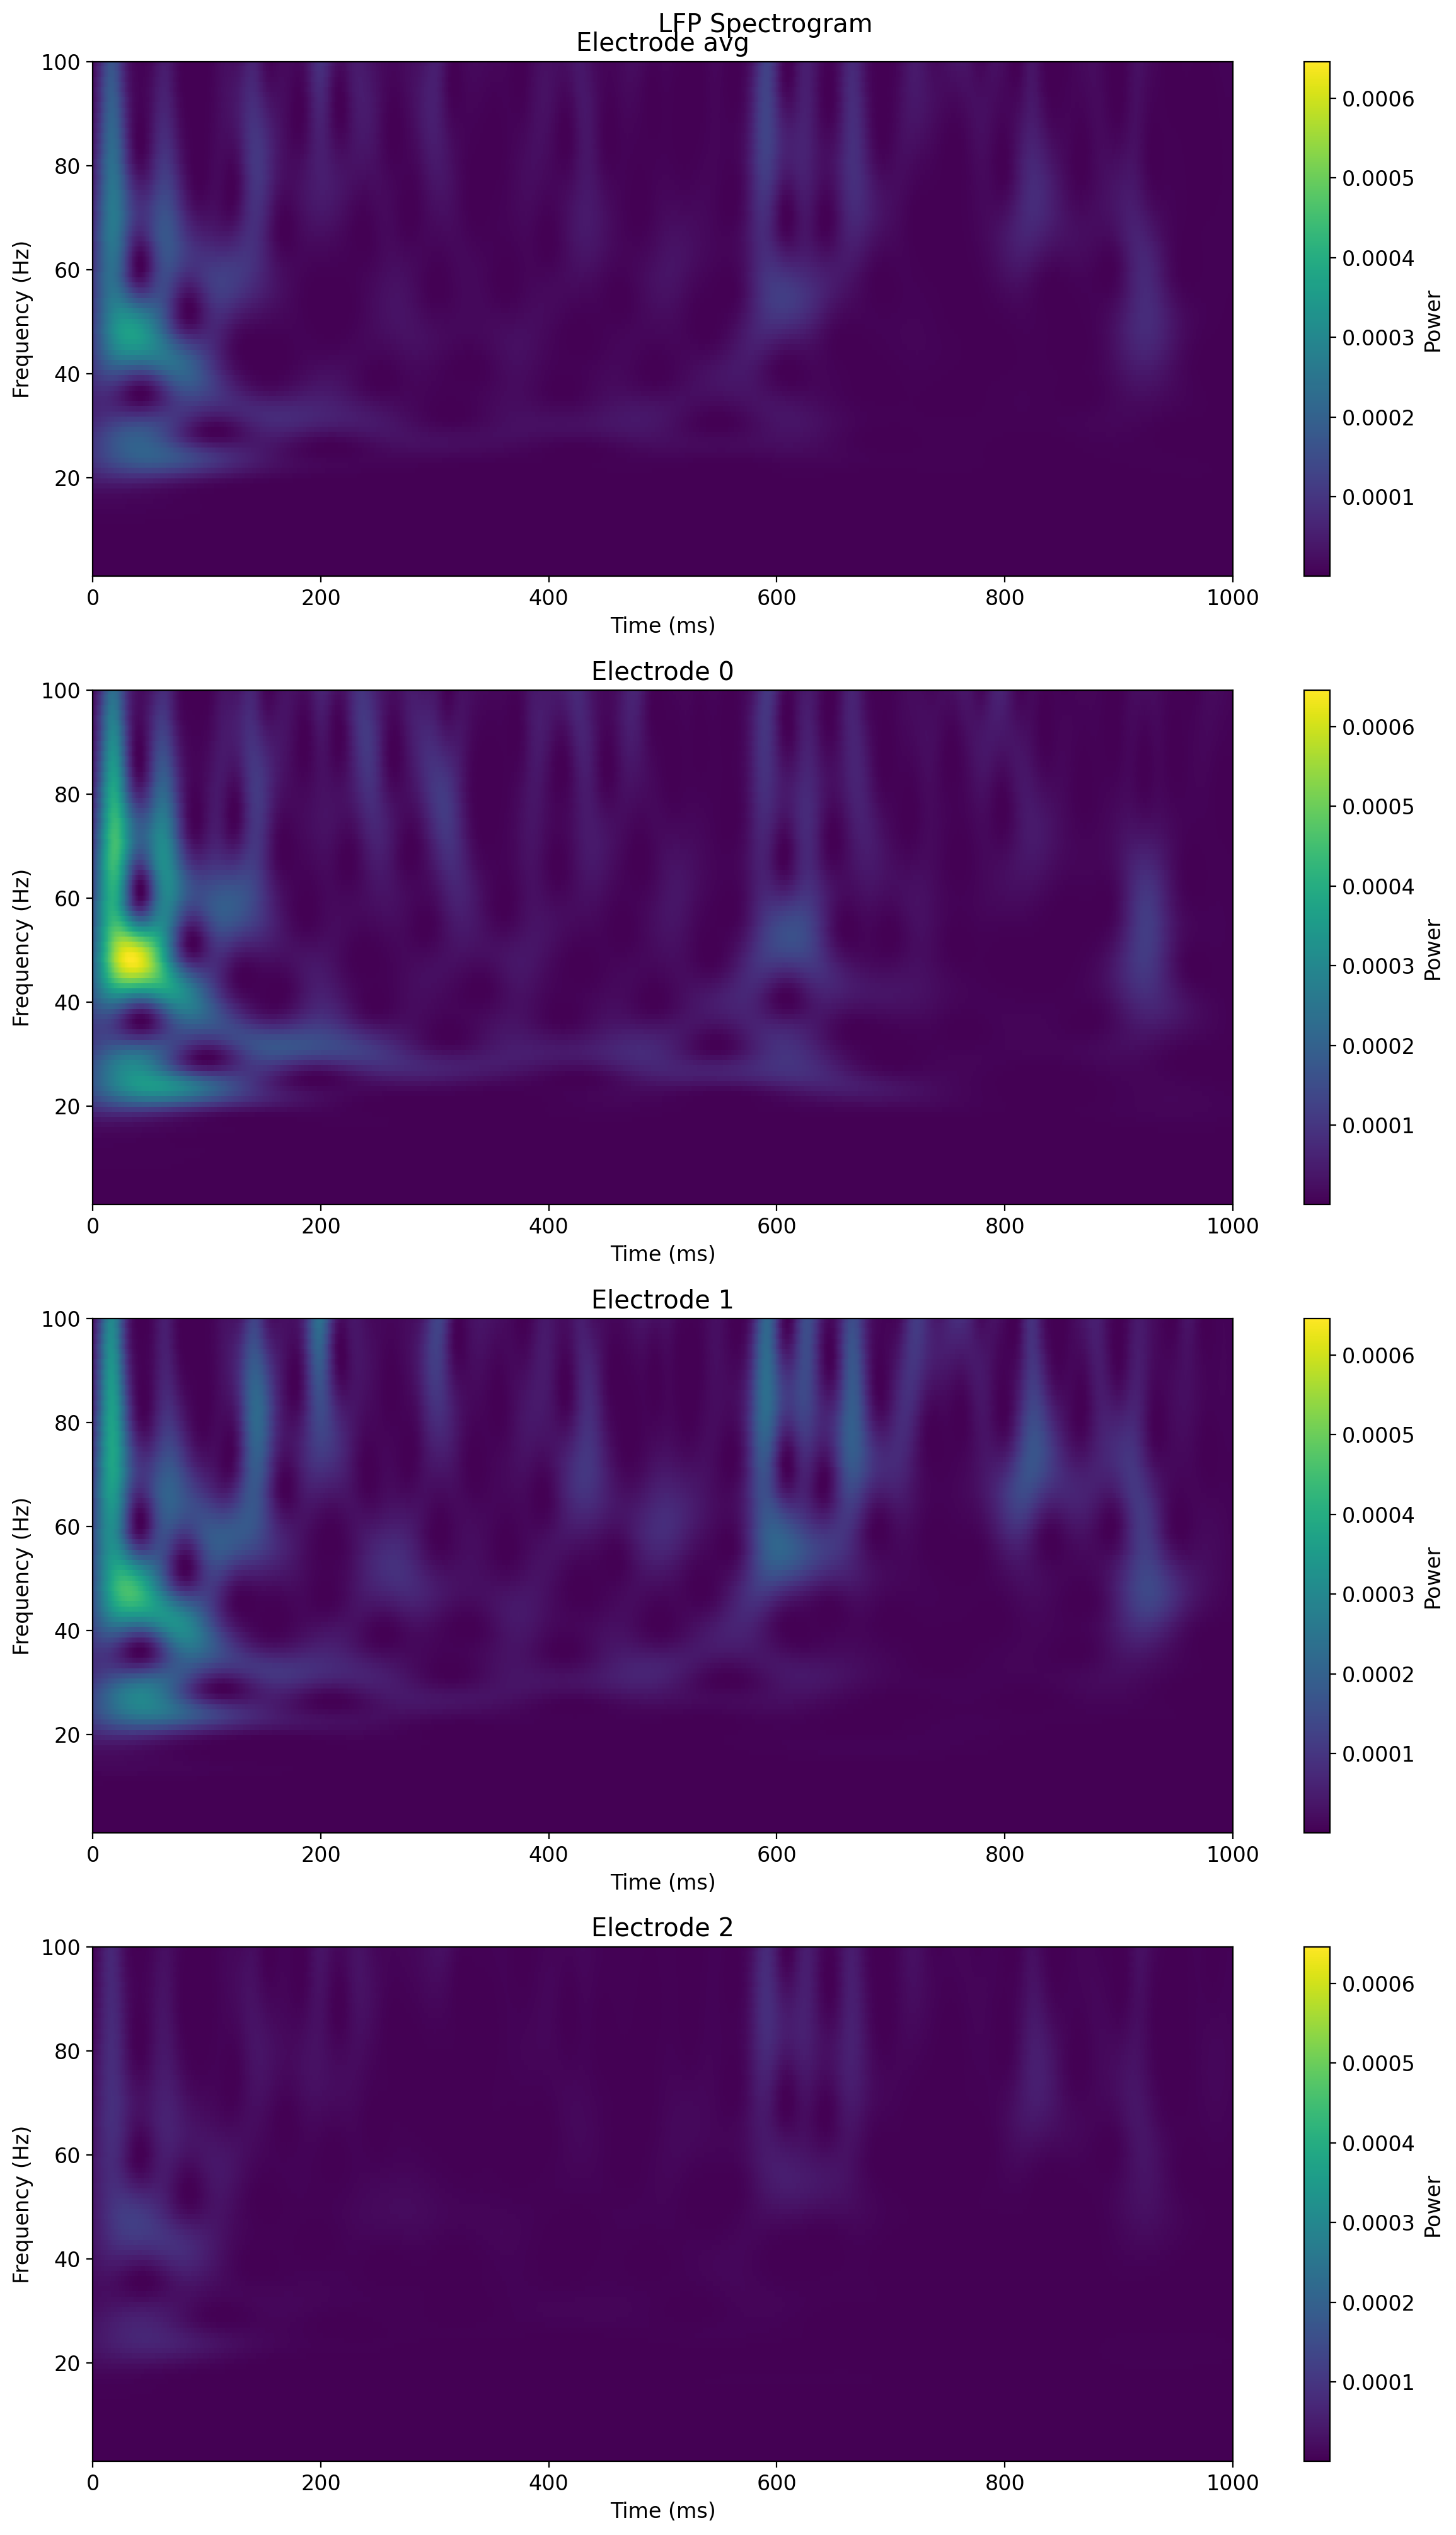

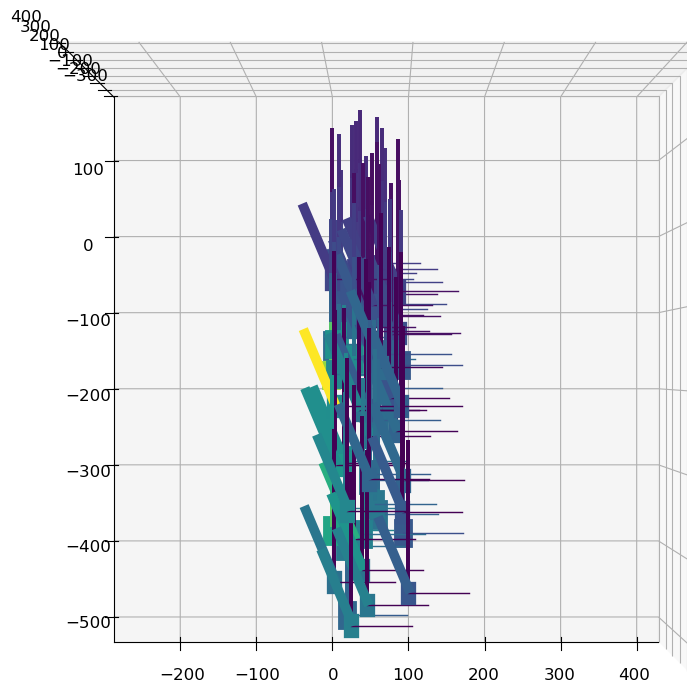

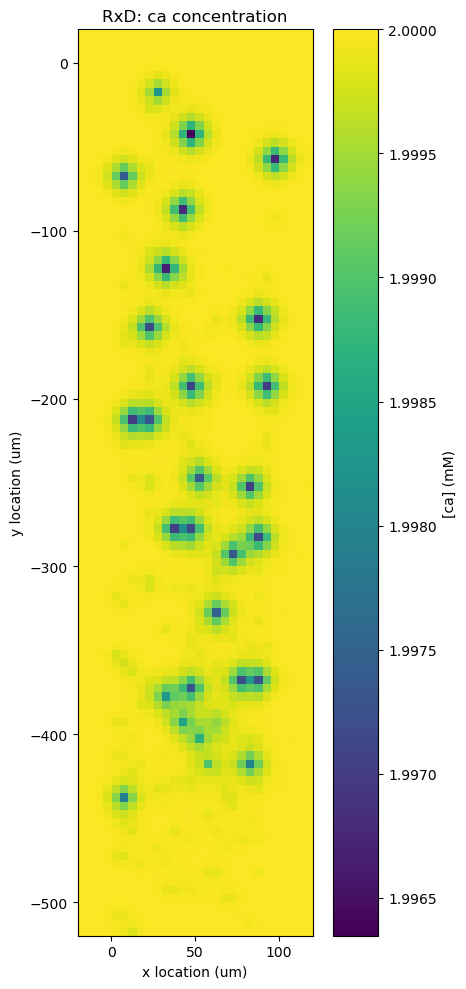

  Done; plotting time = 5.30 s

Total time = 58.80 s


<Figure size 640x480 with 0 Axes>

In [9]:
from netpyne import specs, sim

# should go after importing netpyne
import matplotlib
%matplotlib inline

#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.sizeX = 100 # x-dimension (horizontal length) size in um
netParams.sizeY = 500 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 100 # z-dimension (horizontal length) size in um
netParams.propVelocity = 100.0 # propagation velocity (um/ms)
netParams.probLengthConst = 150.0 # length constant for conn probability (um)

#------------------------------------------------------------------------------
## Cell parameters
netParams.loadCellParams(label='E', fileName='cells/CSTR_cellParams.json')
netParams.importCellParams(label='I', fileName='cells/FScell.hoc', cellName='FScell')


#------------------------------------------------------------------------------
## Population parameters
netParams.popParams['E2'] = {'cellType': 'E', 'numCells': 10, 'yRange': [50,150]}
netParams.popParams['I2'] = {'cellType': 'I', 'numCells': 10, 'yRange': [50,150]}
netParams.popParams['E4'] = {'cellType': 'E', 'numCells': 10, 'yRange': [150,300]}
netParams.popParams['I4'] = {'cellType': 'I', 'numCells': 10, 'yRange': [150,300]}
netParams.popParams['E5'] = {'cellType': 'E', 'numCells': 10, 'ynormRange': [0.6,1.0]}
netParams.popParams['I5'] = {'cellType': 'I', 'numCells': 10, 'ynormRange': [0.6,1.0]}

#------------------------------------------------------------------------------
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

#------------------------------------------------------------------------------
# Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
netParams.stimTargetParams['bkg->E'] = {'source': 'bkg', 'conds': {'cellType': ['E']}, 'weight': 0.02, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}
netParams.stimTargetParams['bkg->I'] = {'source': 'bkg', 'conds': {'cellType': ['I']}, 'weight': 0.004, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

#------------------------------------------------------------------------------
# Cell connectivity rules
netParams.connParams['E->all'] = {
  'preConds': {'cellType': 'E'}, 
  'postConds': {'y': [50,500]},  #  E -> all (100-1000 um)
  'probability': 0.1,                  # probability of connection
  'weight': '0.04*post_ynorm',         # synaptic weight 
  'delay': 'dist_3D/propVelocity',      # transmission delay (ms) 
  'synMech': 'exc'}                     # synaptic mechanism 

netParams.connParams['I->E'] = {
  'preConds': {'cellType': 'I'}, 
  'postConds': {'pop': ['E2','E4','E5']},       #  I -> E
  'probability': '0.3*exp(-dist_3D/probLengthConst)',   # probability of connection
  'weight': 0.01,                                      # synaptic weight 
  'delay': 'dist_3D/propVelocity',                      # transmission delay (ms) 
  'sec': ['soma','Bdend'], 
  'synMech': 'inh'}                                     # synaptic mechanism 



#------------------------------------------------------------------------------
## RxD params

### constants

## Change ip3_init from 0 to 0.1 to observe multiscale effect:  
## netParams.rxdParams['constants']['ip3_init'] = 0.1
## high ip3 -> ER Ca released to Cyt -> kBK channels open -> less firing 

constants = {'ip3_init': 0.0,  # initial ip3 concentration 
            'caDiff': 0.08,  # calcium diffusion coefficient
            'ip3Diff': 1.41,  # ip3 diffusion coefficient
            'caci_init': 1e-5,  # intracellular calcium initial concentration
            'caco_init': 2.0,   # extracellular calcium initial concentration
            'gip3r': 12040 * 100,  # ip3 receptors density
            'gserca': 0.3913,  # SERCA conductance
            'gleak': 6.020,   # ER leak channel conductance
            'kserca': 0.1,  # SERCA reaction constant
            'kip3': 0.15,  # ip3 reaction constant
            'kact': 0.4,  #
            'ip3rtau': 2000,  # ip3 receptors time constant
            'fc': 0.8,  # fraction of cytosol
            'fe': 0.2,  # fraction of ER
            'margin': 20}  # extracellular volume additional margin 

netParams.rxdParams['constants'] = constants

### regions
regions = {}
regions['cyt'] = {'cells': 'all', 'secs': 'all', 'nrn_region': 'i', 'geometry': {'class': 'FractionalVolume', 'args': {'volume_fraction': constants['fc'], 'surface_fraction': 1}}}
regions['er'] = {'cells': 'all', 'secs': 'all', 'geometry': {'class': 'FractionalVolume', 'args': {'volume_fraction': constants['fe']}}}
regions['cyt_er_membrane'] = {'cells': 'all', 'secs': 'all', 'geometry': {'class': 'ScalableBorder', 'args': {'scale': 1, 'on_cell_surface': False}}}

margin = 20  # extracellular volume additional margin 
x, y, z = [0-margin, 100+margin], [-500-margin, 0+margin], [0-margin, 100+margin]
regions['ecs'] = {'extracellular': True, 'xlo': x[0], 'ylo': y[0], 'zlo': z[0], 'xhi': x[1], 'yhi': y[1], 'zhi': z[1], 'dx': 5, 'volume_fraction': 0.2, 'tortuosity': 1.6} 

netParams.rxdParams['regions'] = regions

### species 
species = {}
species['ca'] = {'regions': ['cyt', 'er', 'ecs'], 'd': constants['caDiff'], 'charge': 2,
                'initial': 'caco_init if isinstance(node,rxd.node.NodeExtracellular) else (0.0017 - caci_init * fc) / fe if node.region == er else caci_init'}
species['ip3'] = {'regions': ['cyt'], 'd': constants['ip3Diff'], 'initial': constants['ip3_init']}
netParams.rxdParams['species'] = species

### states
netParams.rxdParams['states'] = {'ip3r_gate_state': {'regions': ['cyt_er_membrane'], 'initial': 0.8}}

### reactions
minf = 'ip3[cyt] * 1000. * ca[cyt] / (ip3[cyt] + kip3) / (1000. * ca[cyt] + kact)'
h_gate = 'ip3r_gate_state[cyt_er_membrane]'
kip3 = 'gip3r * (%s * %s) ** 3' % (minf, h_gate)

mcReactions = {}
mcReactions['serca'] = {'reactant': 'ca[cyt]', 'product': 'ca[er]', 'rate_f': 'gserca / ((kserca / (1000. * ca[cyt])) ** 2 + 1)', 'membrane': 'cyt_er_membrane', 'custom_dynamics': True}
mcReactions['leak'] = {'reactant': 'ca[er]', 'product': 'ca[cyt]', 'rate_f': constants['gleak'], 'rate_b': constants['gleak'], 'membrane': 'cyt_er_membrane'}
mcReactions['ip3r'] = {'reactant': 'ca[er]', 'product': 'ca[cyt]', 'rate_f': kip3, 'rate_b': kip3, 'membrane': 'cyt_er_membrane'}
netParams.rxdParams['multicompartmentReactions'] = mcReactions

### rates
netParams.rxdParams['rates'] = {'ip3rg': {'species': h_gate, 'rate': '(1. / (1 + 1000. * ca[cyt] / (0.3)) - %s) / ip3rtau'%(h_gate)}}




#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

# Run parameters
simConfig = specs.SimConfig()       # object of class simConfig to store simulation configuration
simConfig.duration = 1.0*1e3        # Duration of the simulation, in ms
simConfig.hParams['v_init'] = -65   # set v_init to -65 mV
simConfig.dt = 0.1                  # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages 
simConfig.recordStep = 1             # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'rxd_net'   # Set file output name


# Recording/plotting parameters
simConfig.recordTraces = {'V_soma':{'sec': 'soma','loc': 0.5,'var': 'v'},
                          'ik_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'ik'},
                          'cai_soma': {'sec': 'soma', 'loc':0.5, 'var': 'cai'},
                          'cao_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'cao'}}

simConfig.recordLFP = [[-15, y, 1.0*netParams.sizeZ] for y in range(int(netParams.sizeY/3), int(netParams.sizeY), int(netParams.sizeY/3))]
simConfig.recordDipole = True

simConfig.analysis['plotTraces'] ={'include': [0]}
simConfig.analysis['plotRaster'] = {'orderBy': 'y', 'orderInverse': True, 'saveFig': True, 'figSize': (9,3)}      # Plot a raster
simConfig.analysis['plotLFP'] = {'includeAxon': False, 'figSize': (6,10), 'saveFig': True} 
simConfig.analysis['plotRxDConcentration'] = {'speciesLabel': 'ca', 'regionLabel': 'ecs'}


#from netpyne import sim
sim.createSimulateAnalyze(netParams, simConfig)

Preparing LFP data...
Plotting LFP time series...


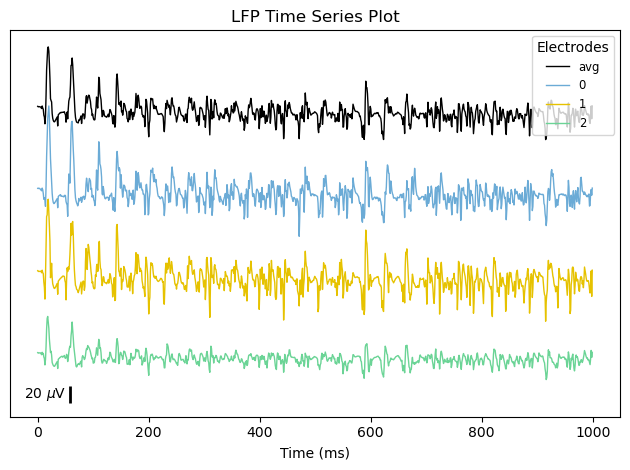

In [18]:
sim.plotting.plotLFPTimeSeries()

Preparing LFP data...
Preparing spectrogram data...
Plotting LFP spectrogram...


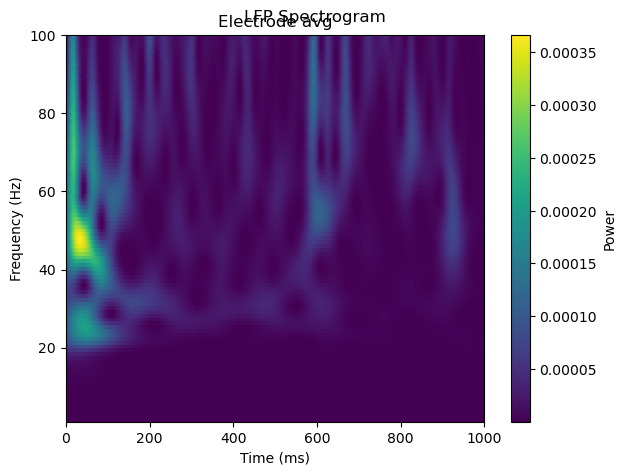

<Figure size 640x480 with 0 Axes>

In [15]:
sim.plotting.plotLFPSpectrogram(electrodes=["avg"])

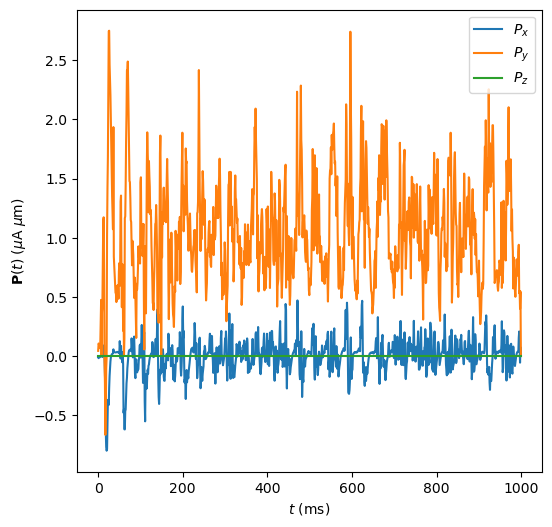

In [16]:
sim.analysis.plotDipole()

Closest electrode to dipole: 16.76 mm


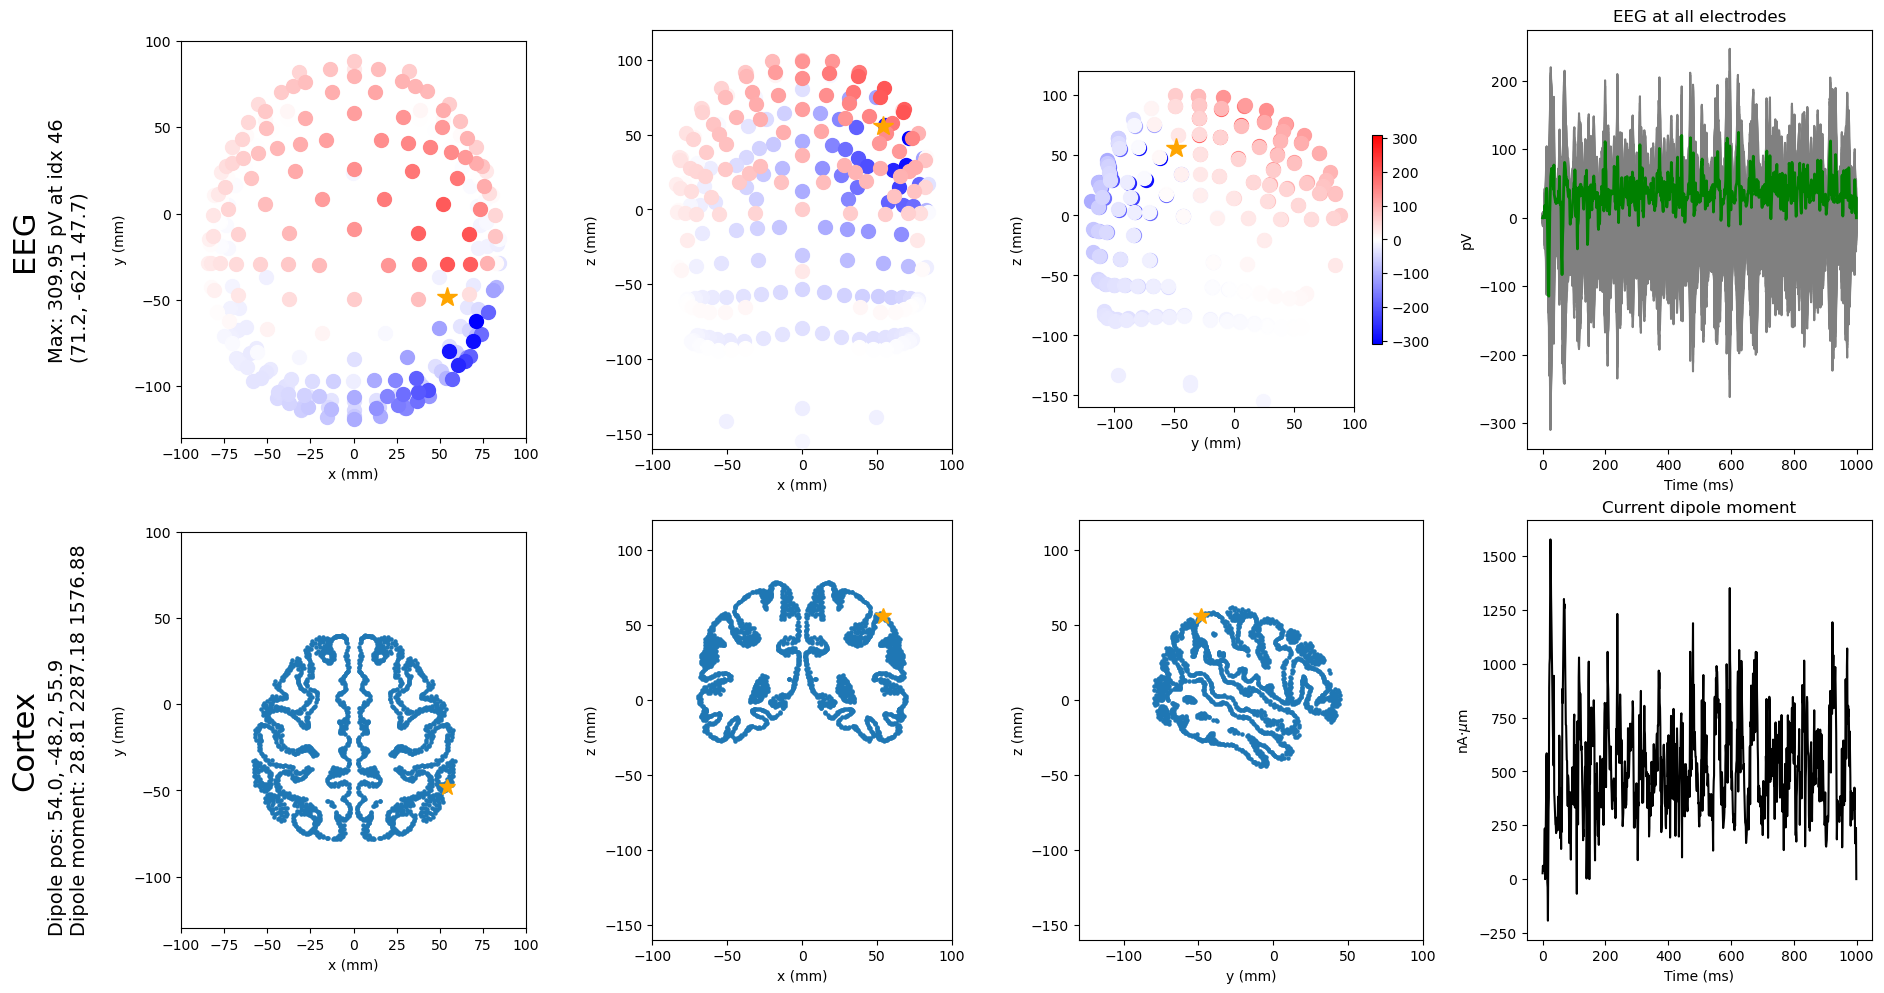

In [17]:
#!pip install h5py
sim.analysis.plotEEG()

Try changing the 'ip3_init' concentration to 0.1 and checking the effect it has on LFP and EEG. 

This demonstrates the effects of changes at the molecular scale affect the cellular and circuit scales, and are reflected in large-scale recording modalities (LFP, EEG). 